# Uncertainty Quantification for Regression with MAPIE

In [109]:
import sys
sys.path.append("..")

from pathlib import Path
from scipy import stats
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from lib.get_config import get_config
cfg = get_config('../config/config.yaml')
import lib.plot_utils as plot_utils

# Set matplotlib default color
from cycler import cycler
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = cycler(color=plot_utils.cb_qualitative_ptol())

Load config file >> ../config/config.yaml


In [2]:
y_rescaled = lambda y_label: yscaler.inverse_transform(np.asarray(y_label)[...,np.newaxis]).flatten()
df = pd.read_csv(Path(cfg['data_dir'], 'catalogue', 'sdssdr16q_prop.csv'), sep=',', header=0)

## Define functions

In [3]:
def evalcv_prederror(estimator, X_test, y_test, y_pred, cv=10):
    """Evaluate prediction error with cross-validation"""
    
    mae = np.abs(y_test - y_pred).mean()
    mae_cv = np.abs(cross_val_score(estimator, X=X_test, y=y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1))
    rmse = np.sqrt(((y_test - y_pred)**2).mean())
    rmse_cv = np.sqrt(np.abs(cross_val_score(estimator, X=X_test, y=y_test, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
    
    return {'mae': mae, 'mae_mean': np.mean(mae_cv), 'mae_stddev': np.std(mae_cv),
            'rmse': rmse, 'rmse_mean': np.mean(rmse_cv), 'rmse_stddev': np.std(rmse_cv)}


In [105]:
def plot_predvstargetuq(target, pred, lower, upper, metrics=None, tstd=None, ax=None, onetoone_refloc=0, xlabel=None, ylabel=None, plot_legend=True, save_plotname=False):
    """Plot prediction against target"""
    
    color = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    # Conformal prediction
    ax.plot(target, pred, marker='.', markersize=2, linestyle=':', lw=1, alpha=0.5, zorder=5, label='prediction')
    ax.fill_between(target, lower, upper, color=next(color), edgecolor='none', alpha=0.3, zorder=5)
    # Metrics
    if isinstance(metrics, dict):
        yoffset = 0.
        for k, v in metrics.items():
            ax.annotate(f"{k}={v:.3f}", xy=(0.05, 0.95+yoffset), xycoords='axes fraction')
            yoffset -= 0.05
    ax = plot_utils.ax_square(ax, identitystd=tstd, identitystd_shade=next(color), plot_identity=True)
    ax.set_xlabel('Target' if xlabel is None else xlabel)
    ax.set_ylabel('Prediction' if ylabel is None else ylabel)
    if plot_legend: ax.legend(loc='lower right')
    if save_plotname: fig.savefig(save_plotname if isinstance(save_plotname, str) else 'plots/widthvsbintarget.pdf', bbox_inches='tight')
    if save_plot: fig.savefig('plots/predvstargetuq.pdf', bbox_inches='tight')
    # plt.show()


def plot_allpredvstargetuq(uq_dict, tstd=0.5, xlabel=None, ylabel=None, save_plotname=False):
    """Plot prediction against target for all uncertainty quantification methods"""
    fig, axes = plt.subplots(2, 3, figsize=(10, 7.5), sharex=True, sharey=True, gridspec_kw={'hspace': 0., 'wspace': 0.})
    nstrategy = len(uq_dict.keys())
    for i, (ax, s) in enumerate(zip(axes.flatten(), uq_dict.keys())):
        plot_predvstargetuq(uq_dict[s]['target'], uq_dict[s]['pred'], uq_dict[s]['lower'], uq_dict[s]['upper'], metrics=uq_dict[s]['pierr_metric'],
                            tstd=tstd, ax=ax, onetoone_refloc=8, xlabel='', ylabel='',
                            plot_legend=True if i==(nstrategy-1) else False, save_plotname=False)
        if i >= nstrategy-3:
            ax.set_xlabel(xlabel)
        if (i % 3) == 0:
            ax.set_ylabel(ylabel)
        ax.set_title(s, fontsize=10)
    if save_plotname: fig.savefig(save_plotname if isinstance(save_plotname, str) else 'plots/allpredvstargetuq.pdf', bbox_inches='tight')
    plt.show()


def plotjoint_widthvstargetuq(uq_dict, strategies=None, xlabel=None, ylabel=None, lu_quantile=None, save_plotname=False):
    """Joint plot of width against target for all uncertainty quantification methods"""
    if strategies is None:
        strategies = uq_dict.keys()
    fig = plt.figure(figsize=(6,6))
    gs = fig.add_gridspec(2, 1, height_ratios=(1,4), top=0.9, hspace=0.)
    # Scatter
    ax = fig.add_subplot(gs[1, 0])
    for strategy in strategies:
        ax.scatter(uq_dict[strategy]['target'], uq_dict[strategy]['upper']-uq_dict[strategy]['lower'], s=3, alpha=0.5, label=strategy)
    # Histogram
    x_target = uq_dict['naive']['target']
    ax_hist = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_hist.hist(x_target, color='gray', bins=30, alpha=0.6)
    ax_hist.tick_params(axis="x", labelbottom=False)
    # Histogram quantile indicator
    if isinstance(lu_quantile, (tuple, list)):
        qline_kwargs = {'ls': '--', 'color': 'gray', 'alpha': 0.6}
        ax.axvline(x=np.quantile(x_target, lu_quantile[0]), **qline_kwargs)
        ax.axvline(x=np.quantile(x_target, lu_quantile[-1]), **qline_kwargs)
        ax_hist.axvline(x=np.quantile(x_target, lu_quantile[0]), **qline_kwargs)
        ax_hist.axvline(x=np.quantile(x_target, lu_quantile[-1]), **qline_kwargs)
    ax.set_xlabel('Target' if xlabel is None else xlabel)
    ax.set_ylabel('Width' if ylabel is None else ylabel)
    ax_hist.set_ylabel('Frequency')
    ax.legend(loc='upper left', markerscale=3)
    if save_plotname: fig.savefig(save_plotname if isinstance(save_plotname, str) else 'plots/jointwidthvstargetuq.pdf', bbox_inches='tight')
    plt.show()


def plot_widthvsbintarget(uq_dict, strategy='cqr', roundto=0.5, xlabel=None, ylabel=None, save_plotname=False):
    """Plot width against number of samples within roundto target bin"""
    roundto_value = lambda value, roundto: np.floor(value*(1./roundto))/(1./roundto)
    # Bin target into counts
    data = uq_dict[strategy]['target']
    hist = np.histogram(data, np.arange(roundto_value(data.min(), roundto), roundto_value(data.max(), roundto)+roundto+roundto, roundto))[0]
    valbin_idx = np.digitize(data, np.arange(roundto_value(data.min(), roundto), roundto_value(data.max(), roundto)+roundto+roundto, roundto))
    valhist = np.asarray([hist[vbi-1] for vbi in valbin_idx])
    valhist_uniq = np.unique(valhist)
    width_vh = []
    valhist_vh = []
    for vh in valhist_uniq:
        mask_vh = valhist==vh
        width_vh.extend((uq_dict[strategy]['upper']-uq_dict[strategy]['lower'])[mask_vh])
        valhist_vh.extend(np.repeat(vh, mask_vh.sum()))
    # Evaluate Spearman correlation
    spearman = stats.spearmanr(valhist_vh, width_vh)
    # Fit linear regression
    # res = stats.linregress(valhist_vh, width_vh)
    # yfit = res.slope*np.asarray(valhist_vh) + res.intercept
    # Fit quantile regression
    qr = QuantileRegressor(quantile=0.5, alpha=0., solver='highs')
    yfit = qr.fit(np.asarray(valhist_vh).reshape(-1, 1), width_vh).predict(np.asarray(valhist_vh).reshape(-1, 1))
    
    fig, ax = plt.subplots(figsize=(6,4))
    
    # Scatter plot
    ax.scatter(valhist_vh, width_vh, s=3, alpha=0.8)
    ax.plot(valhist_vh, yfit, color='gray', lw=2)
    ax.annotate(f"Spearman={spearman.correlation:.3g} ({spearman.pvalue*100.:.3e}%)", xy=(0.5, 0.95), xycoords='axes fraction')
    
    # Violin plot
    # ax.violinplot([(uq_dict[strategy]['upper']-uq_dict[strategy]['lower'])[valhist==vh] for vh in valhist_uniq], showmedians=True)
    # ax.set_xticks(np.arange(1, len(valhist_uniq)+1), labels=valhist_uniq)
    
    ax.set_xlabel(f"Number of Samples within Bin of {roundto}" if xlabel is None else xlabel)
    ax.set_ylabel('Width' if ylabel is None else ylabel)
    ax.grid(axis='x', color='gray', ls='--', alpha=0.6)
    if save_plotname: fig.savefig(save_plotname if isinstance(save_plotname, str) else 'plots/widthvsbintarget.pdf', bbox_inches='tight')
    plt.show()


def plot_picpmpiwvsalpha(df_picp, df_mpiw, save_plotname=False):
    """Plot PICP and MPIW against 1-alpha"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace': 0.2})
    for strategy in df_picp.columns:
        r2scorepercent = 100.*r2_score(1-df_picp.index, df_picp[strategy], force_finite=False)
        axes[0].plot(1-df_picp.index.to_numpy(), df_picp[strategy], '.-', markersize=10, lw=1, alpha=0.8, label=rf"$R^{2}_\mathrm{{{strategy.replace('_', ' ')}}}={r2scorepercent:.2f}$%")
        axes[1].plot(1-df_mpiw.index.to_numpy(), df_mpiw[strategy], '.-', markersize=10, lw=1, alpha=0.8, label=strategy)
    for ax in axes:
        ax.set_xlim(0, 1)
        ax.set_xlabel(r"$(1-\alpha)$ Confidence Level")
        ax.legend(handlelength=1.5, labelspacing=0.2)
    axes[0].axline([1, 1], slope=1, ls='--', color='gray', alpha=0.6)
    axes[0].set_ylim(0, 1)
    axes[1].set_ylim(0, None)
    axes[0].set_ylabel("PICP")
    axes[1].set_ylabel("MPIW")
    if save_plotname: fig.savefig(save_plotname if isinstance(save_plotname, str) else 'plots/picpmpiwvsalpha.pdf', bbox_inches='tight')
    plt.show()


## For H$\beta$ virial BH mass

### Load output files

In [92]:
# Features
logdir_exp = Path(cfg['data_dir'], 'logs', '20230323/000956_LOGMBH_HB')

datasplit_idx = pd.read_pickle(Path(logdir_exp, 'datasplitidx.pkl'))
datasplit_idx['valid'], datasplit_idx['test'] = train_test_split(datasplit_idx['test'], test_size=cfg['frac_test_size'], random_state=cfg['seed'])
df_features = pd.read_pickle(Path(logdir_exp, 'features.pkl'))
yscaler = pd.read_pickle(Path(logdir_exp, 'yscaler.pkl'))

feature_keys = [k for k in df_features.columns if isinstance(k, int)]
dffeatures_train = df_features.loc[datasplit_idx['train']]
dffeatures_valid = df_features.loc[datasplit_idx['valid']]
dffeatures_test = df_features.loc[datasplit_idx['test']]
df_test = pd.merge(dffeatures_test['objid'], df, how='inner', left_on=['objid'], right_on=['OBJID'])

In [93]:
# Regressors
estimator = pd.read_pickle(Path(logdir_exp, 'estimator_optim.pkl'))
print(f"Best estimator >> {estimator}")
estimator_q = pd.read_pickle(Path(logdir_exp, 'estimatorq_optim.pkl'))
print(f"Best estimator >> {estimator_q}")
y_pred_hbeta, y_pis_hbeta, uq_dict = pd.read_pickle(Path(logdir_exp, 'mapieuq_pred.pkl'))
df_picp = pd.read_pickle(Path(logdir_exp, 'mapieuq_picp_alpha.pkl'))
df_mpiw = pd.read_pickle(Path(logdir_exp, 'mapieuq_mpiw_alpha.pkl'))

Best estimator >> GradientBoostingRegressor(learning_rate=0.013264961159866528, max_depth=26,
                          max_leaf_nodes=15, n_estimators=251, random_state=42)
Best estimator >> GradientBoostingRegressor(alpha=0.5, learning_rate=0.1014715428660321,
                          loss='quantile', max_depth=4, max_leaf_nodes=26,
                          n_estimators=358, random_state=42)


### Prediction results

In [13]:
# Evaluate prediction error
pd.DataFrame(
    {str(estimator).rpartition('(')[0]: evalcv_prederror(estimator, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred['cv_plus'], cv=10)} | \
    {str(estimator_q).rpartition('(')[0]+'_quantile': evalcv_prederror(estimator_q, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred['cqr'], cv=10)}
).style.format('{:.3f}')


,GradientBoostingRegressor,GradientBoostingRegressor_quantile
mae,0.128,0.127
mae_mean,0.131,0.131
mae_stddev,0.010,0.010
rmse,0.174,0.174
rmse_mean,0.175,0.176
rmse_stddev,0.019,0.017


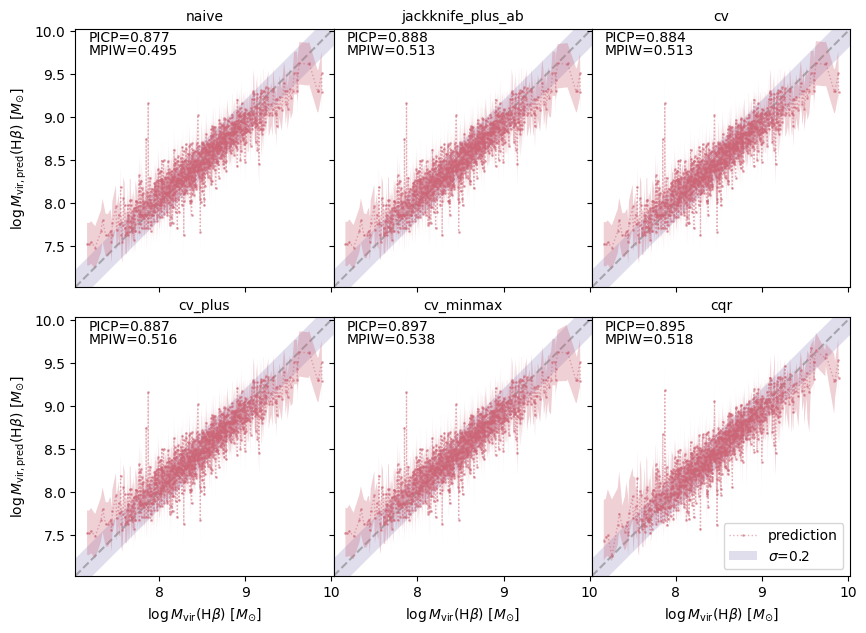

In [85]:
# For single method
# s = 'cqr'
# plot_predvstargetuq(uq_dict[s]['target'], uq_dict[s]['pred'], uq_dict[s]['lower'], uq_dict[s]['upper'], metrics=uq_dict[s]['pierr_metric'], tstd=0.5, ax=None, onetoone_refloc=8,
#                     xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{H}\beta)\ [M_{\odot}]$',
#                     save_plotname=False)

# For all
plot_allpredvstargetuq(uq_dict, tstd=0.2,
                        xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{H}\beta)\ [M_{\odot}]$',
                        save_plotname='plots/allpredvstargetuq_hbeta.pdf')

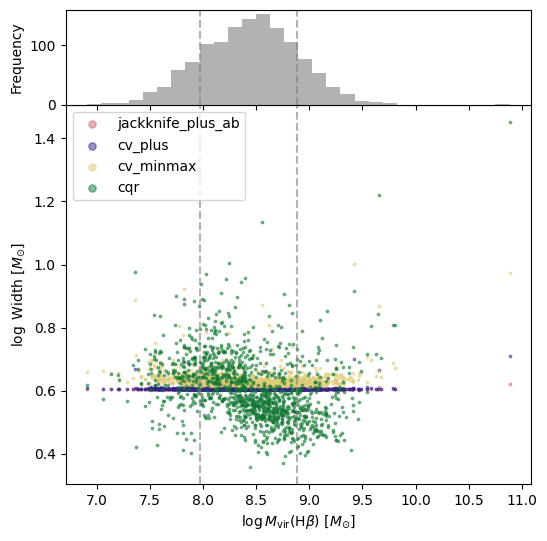

In [29]:
plotjoint_widthvstargetuq(uq_dict, strategies=['jackknife_plus_ab', 'cv_plus', 'cv_minmax', 'cqr'],
                          xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$', ylabel=r'$\log$ Width $[M_{\odot}]$',
                          lu_quantile=[0.5-0.6827/2, 0.5+0.6827/2], save_plotname='plots/jointwidthvstargetuq_hbeta.pdf')

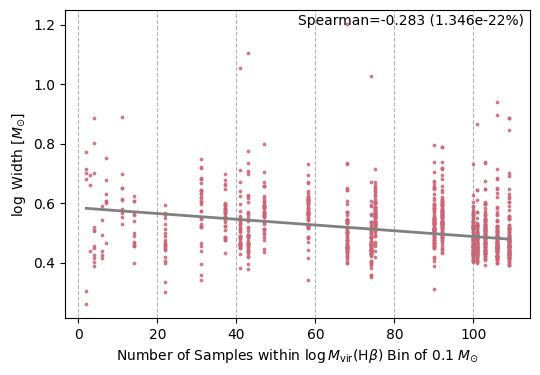

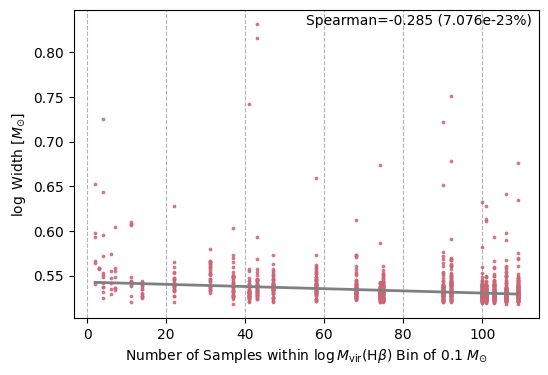

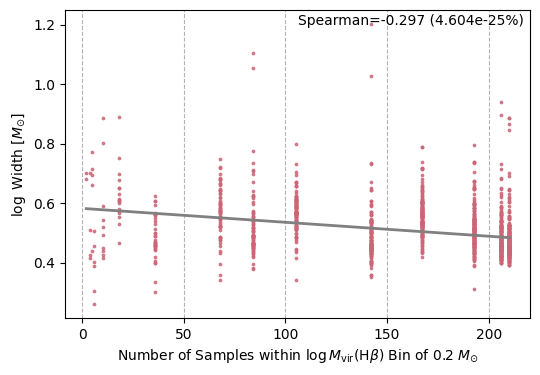

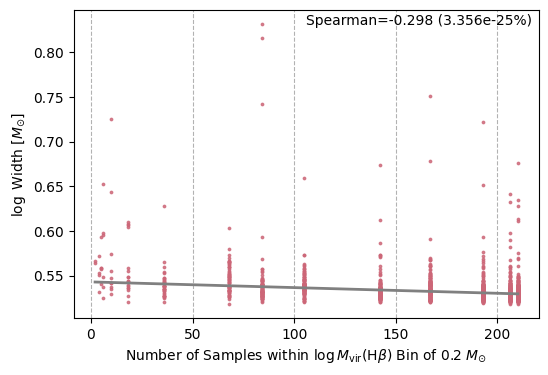

In [118]:
# For one sized
# plot_widthvsbintarget(uq_dict, strategy='cqr', roundto=0.2,
#                       xlabel=rf"Number of Samples within $\log M_{{\mathrm{{vir}}}}(\mathrm{{H}}\beta)$ Bin of {b:.1f} $M_{{\odot}}$", ylabel=r'$\log$ Width $[M_{\odot}]$',
#                       save_plotname=False)

# For a range
for b in np.arange(0.1, 0.3, 0.1):
    plot_widthvsbintarget(uq_dict, strategy='cqr', roundto=b,
                          xlabel=rf"Number of Samples within $\log M_{{\mathrm{{vir}}}}(\mathrm{{H}}\beta)$ Bin of {b:.1f} $M_{{\odot}}$", ylabel=r'$\log$ Width $[M_{\odot}]$',
                          save_plotname=f"plots/widthvsbintarget_hbeta_cqr_bin{b:.1f}.pdf")
    plot_widthvsbintarget(uq_dict, strategy='cv_minmax', roundto=b,
                          xlabel=rf"Number of Samples within $\log M_{{\mathrm{{vir}}}}(\mathrm{{H}}\beta)$ Bin of {b:.1f} $M_{{\odot}}$", ylabel=r'$\log$ Width $[M_{\odot}]$',
                          save_plotname=f"plots/widthvsbintarget_hbeta_cv_minmax_bin{b:.1f}.pdf")

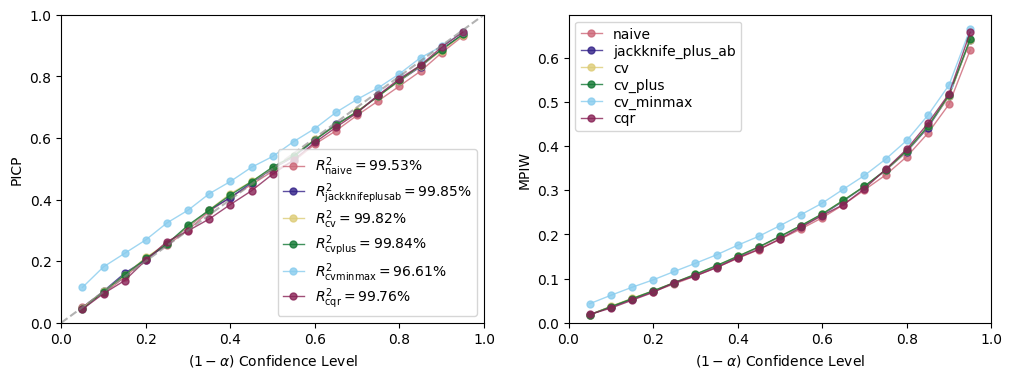

In [94]:
plot_picpmpiwvsalpha(df_picp, df_mpiw, save_plotname='plots/picpmpiwvsalpha_hbeta.pdf')

## For MgII virial BH mass

### Load output files

In [89]:
# Features
logdir_exp = Path(cfg['data_dir'], 'logs', '20230323/142847_LOGMBH_MGII')

datasplit_idx = pd.read_pickle(Path(logdir_exp, 'datasplitidx.pkl'))
datasplit_idx['valid'], datasplit_idx['test'] = train_test_split(datasplit_idx['test'], test_size=cfg['frac_test_size'], random_state=cfg['seed'])
df_features = pd.read_pickle(Path(logdir_exp, 'features.pkl'))
yscaler = pd.read_pickle(Path(logdir_exp, 'yscaler.pkl'))

feature_keys = [k for k in df_features.columns if isinstance(k, int)]
dffeatures_train = df_features.loc[datasplit_idx['train']]
dffeatures_valid = df_features.loc[datasplit_idx['valid']]
dffeatures_test = df_features.loc[datasplit_idx['test']]

In [90]:
# Regressors
estimator = pd.read_pickle(Path(logdir_exp, 'estimator_optim.pkl'))
print(f"Best estimator >> {estimator}")
estimator_q = pd.read_pickle(Path(logdir_exp, 'estimatorq_optim.pkl'))
print(f"Best estimator >> {estimator_q}")
y_pred_mgii, y_pis_mgii, uq_dict = pd.read_pickle(Path(logdir_exp, 'mapieuq_pred.pkl'))
df_picp = pd.read_pickle(Path(logdir_exp, 'mapieuq_picp_alpha.pkl'))
df_mpiw = pd.read_pickle(Path(logdir_exp, 'mapieuq_mpiw_alpha.pkl'))

Best estimator >> GradientBoostingRegressor(learning_rate=0.013264961159866528, max_depth=26,
                          max_leaf_nodes=15, n_estimators=251, random_state=42)
Best estimator >> GradientBoostingRegressor(alpha=0.5, learning_rate=0.050768531039396936,
                          loss='quantile', max_depth=20, max_leaf_nodes=24,
                          n_estimators=152, random_state=42)


### Prediction results

In [21]:
# Evaluate prediction error
pd.DataFrame(
    {str(estimator).rpartition('(')[0]: evalcv_prederror(estimator, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred['cv_plus'], cv=10)} | \
    {str(estimator_q).rpartition('(')[0]+'_quantile': evalcv_prederror(estimator_q, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred['cqr'], cv=10)}
).style.format('{:.3f}')


,GradientBoostingRegressor,GradientBoostingRegressor_quantile
mae,0.146,0.147
mae_mean,0.152,0.150
mae_stddev,0.006,0.004
rmse,0.192,0.193
rmse_mean,0.201,0.201
rmse_stddev,0.015,0.014


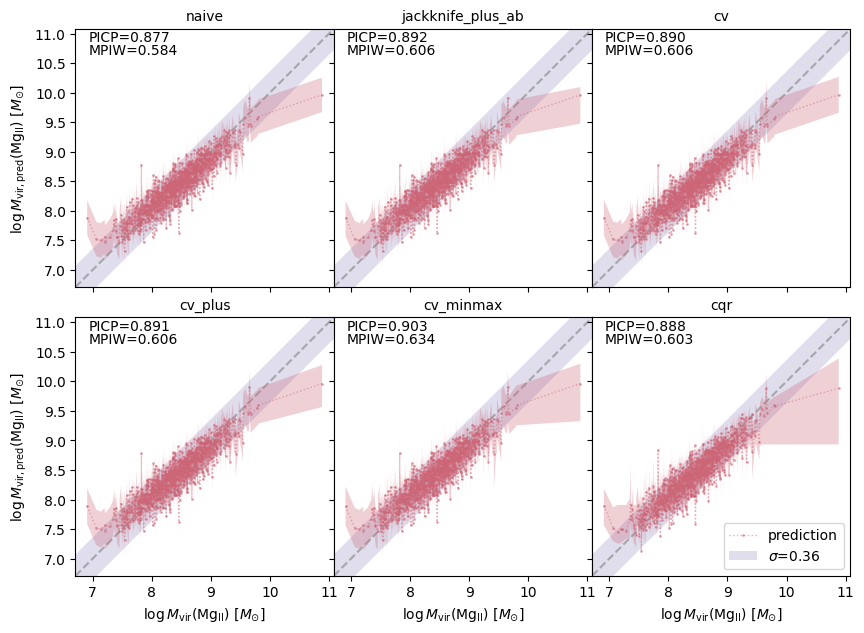

In [91]:
# For single method
# s = 'cqr'
# plot_predvstargetuq(uq_dict[s]['target'], uq_dict[s]['pred'], uq_dict[s]['lower'], uq_dict[s]['upper'], metrics=uq_dict[s]['pierr_metric'], tstd=0.5, ax=None, onetoone_refloc=8,
#                     xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{Mg}_{\mathrm{II}})\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{Mg}_{\mathrm{II}})\ [M_{\odot}]$',
#                     save_plotname=False)

# For all
plot_allpredvstargetuq(uq_dict, tstd=0.36,
                       xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{Mg}_{\mathrm{II}})\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{Mg}_{\mathrm{II}})\ [M_{\odot}]$',
                       save_plotname='plots/allpredvstargetuq_mgii.pdf')

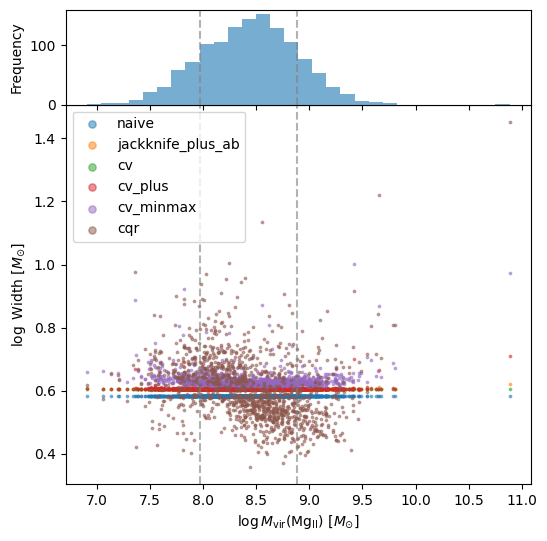

In [23]:
plotjoint_widthvstargetuq(uq_dict,
                          xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{Mg}_{\mathrm{II}})\ [M_{\odot}]$', ylabel=r'$\log$ Width $[M_{\odot}]$',
                          lu_quantile=[0.5-0.6827/2, 0.5+0.6827/2], save_plotname='plots/jointwidthvstargetuq_mgii.pdf')

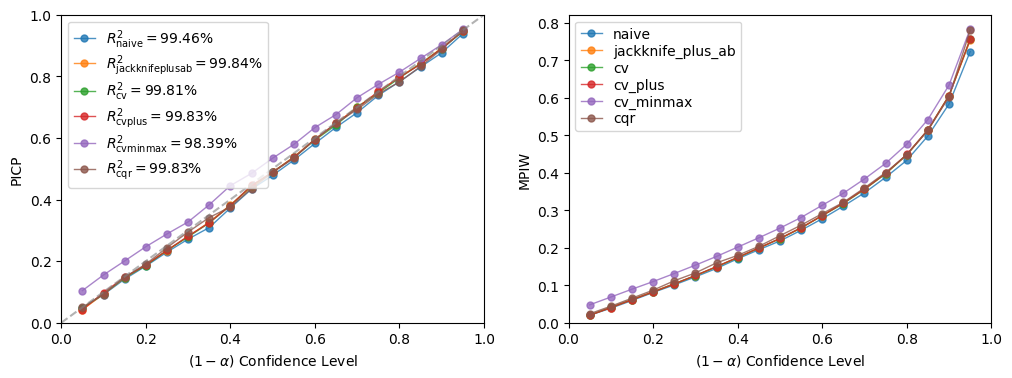

In [24]:
plot_picpmpiwvsalpha(df_picp, df_mpiw, save_plotname='plots/picpmpiwvsalpha_mgii.pdf')

## Additional Experiments

(a) Selected subsamples of evenly sampled $M_{vir}=8-9 M_{\odot}$

## (a) For Hb virial BH mass

### Load output files

In [ ]:
# Features
logdir_exp = Path(cfg['data_dir'], 'logs', '20230309/150244_LOGMBH_HB')

datasplit_idx = pd.read_pickle(Path(logdir_exp, 'datasplitidx.pkl'))
datasplit_idx['valid'], datasplit_idx['test'] = train_test_split(datasplit_idx['test'], test_size=cfg['frac_test_size'], random_state=cfg['seed'])
df_features = pd.read_pickle(Path(logdir_exp, 'features.pkl'))
yscaler = pd.read_pickle(Path(logdir_exp, 'yscaler.pkl'))

feature_keys = [k for k in df_features.columns if isinstance(k, int)]
dffeatures_train = df_features.loc[datasplit_idx['train']]
dffeatures_valid = df_features.loc[datasplit_idx['valid']]
dffeatures_test = df_features.loc[datasplit_idx['test']]

In [ ]:
# Regressors
estimator = pd.read_pickle(Path(logdir_exp, 'estimator_optim.pkl'))
print(f"Best estimator >> {estimator}")
estimator_q = pd.read_pickle(Path(logdir_exp, 'estimatorq_optim.pkl'))
print(f"Best estimator >> {estimator_q}")
y_pred, y_pis, uq_dict = pd.read_pickle(Path(logdir_exp, 'mapieuq_pred.pkl'))
df_picp = pd.read_pickle(Path(logdir_exp, 'mapieuq_picp_alpha.pkl'))
df_mpiw = pd.read_pickle(Path(logdir_exp, 'mapieuq_mpiw_alpha.pkl'))

### Prediction results

In [20]:
# Evaluate prediction error
pd.DataFrame(
    {str(estimator).rpartition('(')[0]: evalcv_prederror(estimator, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred['cv_plus'], cv=10)} | \
    {str(estimator_q).rpartition('(')[0]+'_quantile': evalcv_prederror(estimator_q, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred['cqr'], cv=10)}
).style.format('{:.3f}')


,RandomForestRegressor,GradientBoostingRegressor
mae,0.105,0.105
mae_mean,0.105,0.109
mae_stddev,0.010,0.010
rmse,0.140,0.141
rmse_mean,0.136,0.140
rmse_stddev,0.012,0.012


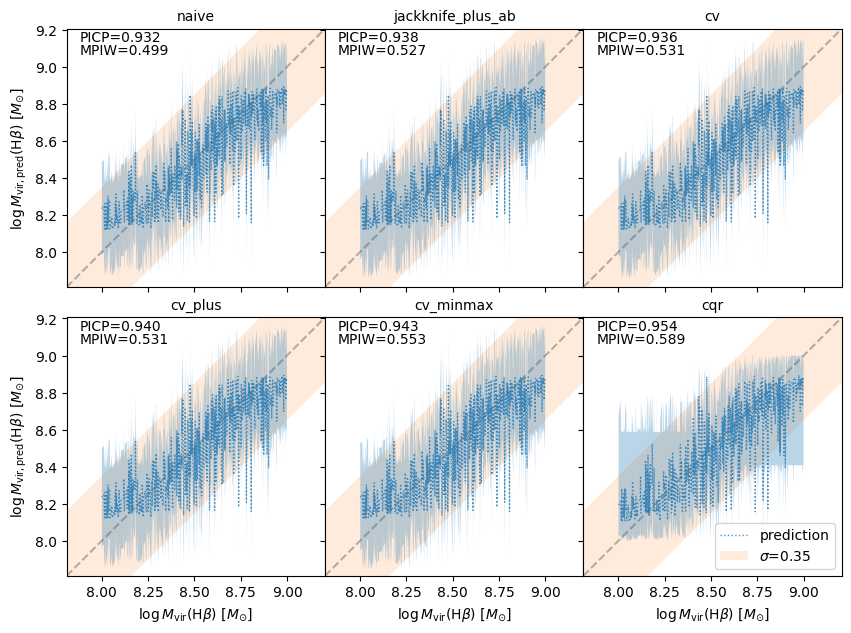

In [21]:
# For single method
# s = 'cqr'
# plot_predvstargetuq(uq_dict[s]['target'], uq_dict[s]['pred'], uq_dict[s]['lower'], uq_dict[s]['upper'], metrics=uq_dict[s]['pierr_metric'], tstd=0.5, ax=None, onetoone_refloc=8,
#                     xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{H}\beta)\ [M_{\odot}]$',
#                     save_plot=False)

# For all
plot_allpredvstargetuq(uq_dict, tstd=0.35,
                        xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{H}\beta)\ [M_{\odot}]$',
                        save_plot=True)

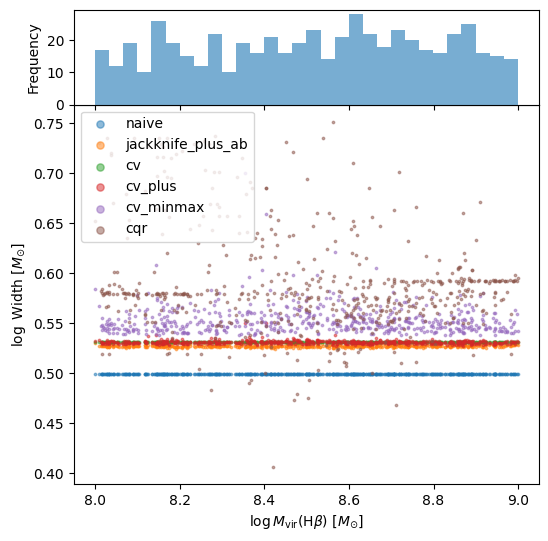

In [22]:
plotjoint_widthvstargetuq(uq_dict,
                          xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$', ylabel=r'$\log$ Width $[M_{\odot}]$',
                          lu_quantile=None, save_plot=True)

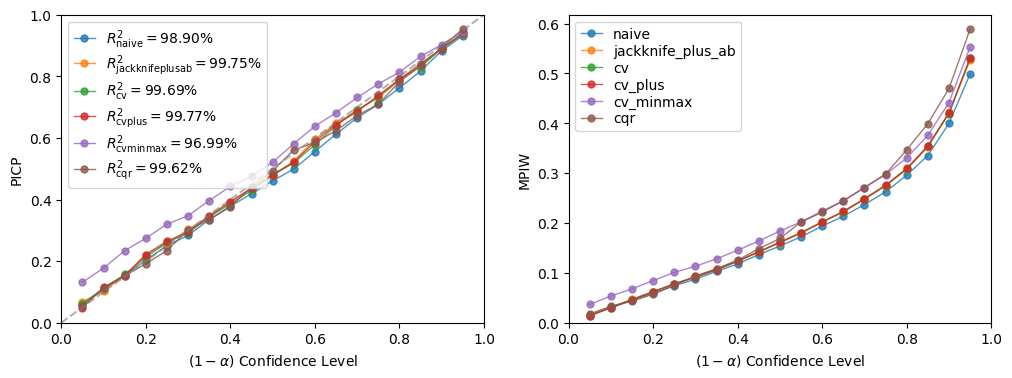

In [23]:
plot_picpmpiwvsalpha(df_picp, df_mpiw, save_plot=True)

## (a) For MgII virial BH mass

### Load output files

In [ ]:
# Features
logdir_exp = Path(cfg['data_dir'], 'logs', '20230309/163305_LOGMBH_MGII')

datasplit_idx = pd.read_pickle(Path(logdir_exp, 'datasplitidx.pkl'))
datasplit_idx['valid'], datasplit_idx['test'] = train_test_split(datasplit_idx['test'], test_size=cfg['frac_test_size'], random_state=cfg['seed'])
df_features = pd.read_pickle(Path(logdir_exp, 'features.pkl'))
yscaler = pd.read_pickle(Path(logdir_exp, 'yscaler.pkl'))

feature_keys = [k for k in df_features.columns if isinstance(k, int)]
dffeatures_train = df_features.loc[datasplit_idx['train']]
dffeatures_valid = df_features.loc[datasplit_idx['valid']]
dffeatures_test = df_features.loc[datasplit_idx['test']]

In [ ]:
# Regressors
estimator = pd.read_pickle(Path(logdir_exp, 'estimator_optim.pkl'))
print(f"Best estimator >> {estimator}")
estimator_q = pd.read_pickle(Path(logdir_exp, 'estimatorq_optim.pkl'))
print(f"Best estimator >> {estimator_q}")
y_pred, y_pis, uq_dict = pd.read_pickle(Path(logdir_exp, 'mapieuq_pred.pkl'))
df_picp = pd.read_pickle(Path(logdir_exp, 'mapieuq_picp_alpha.pkl'))
df_mpiw = pd.read_pickle(Path(logdir_exp, 'mapieuq_mpiw_alpha.pkl'))

### Prediction results

In [26]:
# Evaluate prediction error
pd.DataFrame(
    {str(estimator).rpartition('(')[0]: evalcv_prederror(estimator, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred['cv_plus'], cv=10)} | \
    {str(estimator_q).rpartition('(')[0]+'_quantile': evalcv_prederror(estimator_q, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred['cqr'], cv=10)}
).style.format('{:.3f}')


,RandomForestRegressor,GradientBoostingRegressor
mae,0.120,0.121
mae_mean,0.125,0.128
mae_stddev,0.013,0.014
rmse,0.155,0.157
rmse_mean,0.161,0.164
rmse_stddev,0.012,0.012


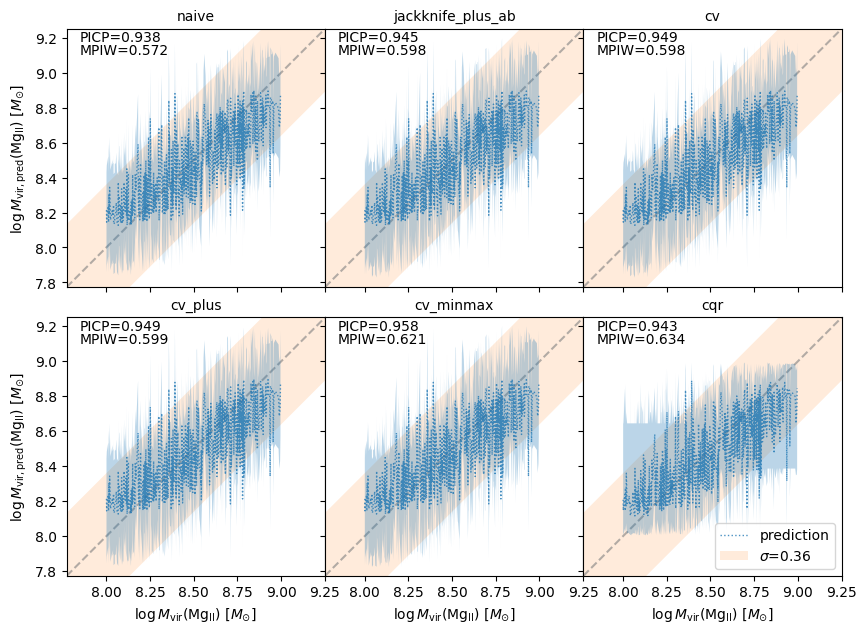

In [27]:
# For single method
# s = 'cqr'
# plot_predvstargetuq(uq_dict[s]['target'], uq_dict[s]['pred'], uq_dict[s]['lower'], uq_dict[s]['upper'], metrics=uq_dict[s]['pierr_metric'], tstd=0.5, ax=None, onetoone_refloc=8,
#                     xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{Mg}_{\mathrm{II}})\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{Mg}_{\mathrm{II}})\ [M_{\odot}]$',
#                     save_plot=False)

# For all
plot_allpredvstargetuq(uq_dict, tstd=0.36,
                       xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{Mg}_{\mathrm{II}})\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{Mg}_{\mathrm{II}})\ [M_{\odot}]$',
                       save_plot=True)

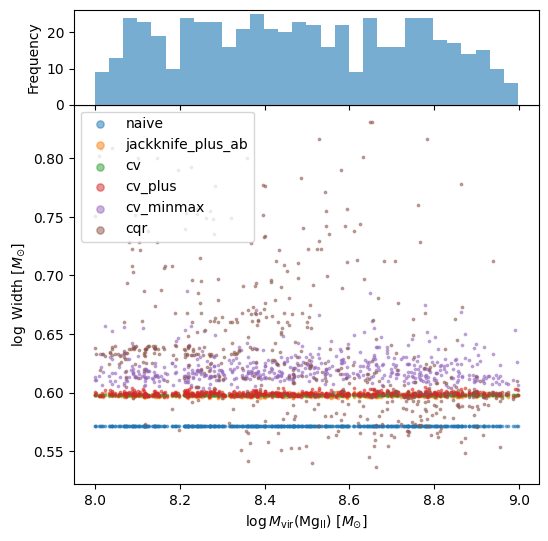

In [28]:
plotjoint_widthvstargetuq(uq_dict,
                          xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{Mg}_{\mathrm{II}})\ [M_{\odot}]$', ylabel=r'$\log$ Width $[M_{\odot}]$',
                          lu_quantile=None, save_plot=True)

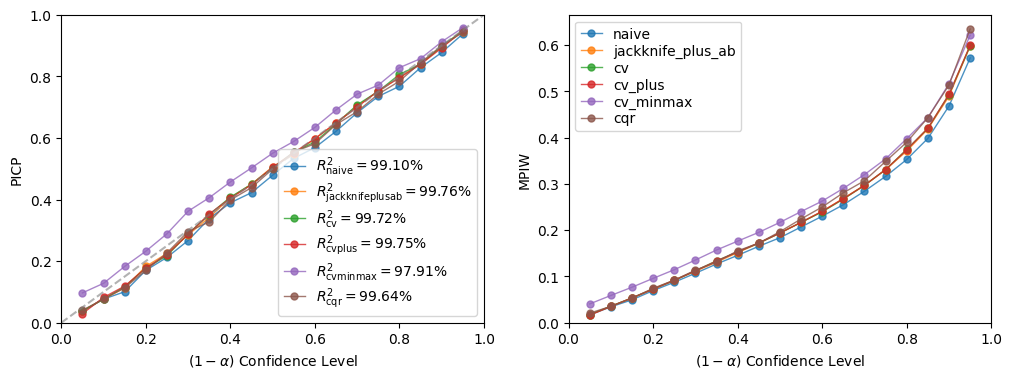

In [29]:
plot_picpmpiwvsalpha(df_picp, df_mpiw, save_plot=True)